Đánh giá Pipeline NER và RE

Notebook này thực hiện 3 nhiệm vụ chính:
1. Đánh giá riêng lẻ các mô hình RE (4 Vectorizers x 4 Models) trên Gold Standard Entities.
2. Đánh giá Pipeline kết hợp (NER -> RE): Dùng output của NER làm input cho RE.

In [1]:
import sys
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Thêm đường dẫn src
CURRENT_DIR = Path(os.getcwd())
BASE_DIR = CURRENT_DIR.parent
SRC_DIR = os.path.join(BASE_DIR, 'src')
sys.path.append(SRC_DIR)

from evaluate import evaluate_re_module, inference_pipeline, evaluate_pipeline
from utils import MODEL_DIR, DATA_DIR

# Định nghĩa đường dẫn
TEST_JSON = os.path.join(DATA_DIR, 'processed', 'test_tasks.json')
TEST_CSV = os.path.join(DATA_DIR, 'processed', 'test_data.csv')
NER_MODEL_PATH = os.path.join(MODEL_DIR, 'ner_bert_model')

c:\Users\ASUS\anaconda3\envs\mynewenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


=== ĐÁNH GIÁ VÀ SO SÁNH CÁC MODEL RE ===
Tìm thấy 38 files. Đang lọc và đánh giá...
--> Đang đánh giá: LogisticRegression với bert...
--> Đang đánh giá: LogisticRegression với bow...
--> Đang đánh giá: LogisticRegression với tfidf...
--> Đang đánh giá: LogisticRegression với w2v...
--> Đang đánh giá: MLPDeepLearning với bert...
--> Đang đánh giá: MLPDeepLearning với bow...
--> Đang đánh giá: MLPDeepLearning với tfidf...
--> Đang đánh giá: MLPDeepLearning với w2v...
--> Đang đánh giá: RandomForest với bert...
--> Đang đánh giá: RandomForest với bow...
--> Đang đánh giá: RandomForest với tfidf...
--> Đang đánh giá: RandomForest với w2v...
--> Đang đánh giá: SVM với bert...
--> Đang đánh giá: SVM với bow...
--> Đang đánh giá: SVM với tfidf...
--> Đang đánh giá: SVM với w2v...

=== BẢNG XẾP HẠNG MODEL (Dựa trên F1-Macro) ===


,Model,Vectorizer,Accuracy,F1-Macro
4,MLPDeepLearning,bert,0.719643,0.562711
12,SVM,bert,0.617857,0.533074
9,RandomForest,bow,0.644643,0.506872
10,RandomForest,tfidf,0.666071,0.503881
13,SVM,bow,0.608929,0.497314
0,LogisticRegression,bert,0.550000,0.465802
1,LogisticRegression,bow,0.517857,0.463651
5,MLPDeepLearning,bow,0.692857,0.462745
8,RandomForest,bert,0.701786,0.456025
6,MLPDeepLearning,tfidf,0.603571,0.410666



Model tốt nhất: MLPDeepLearning (bert)


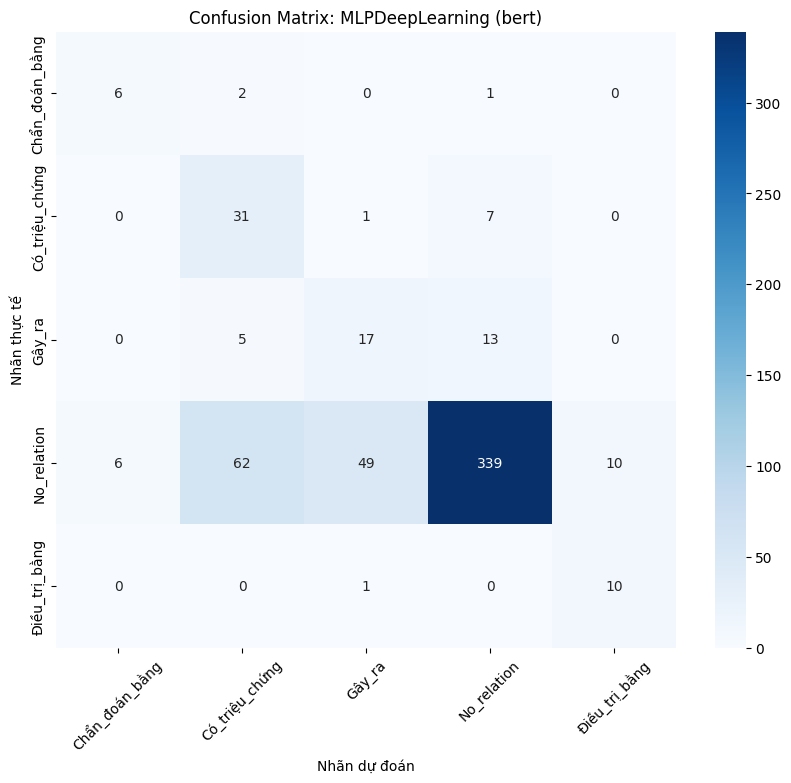

In [2]:
# CELL 2: TỰ ĐỘNG ĐÁNH GIÁ VÀ SO SÁNH TẤT CẢ MODEL RE
print("=== ĐÁNH GIÁ VÀ SO SÁNH CÁC MODEL RE ===")

# Tìm tất cả file model .pkl trong folder models
# Quy tắc đặt tên: {model_name}_{vec_name}.pkl (ví dụ: RandomForest_bow.pkl)
model_files = glob.glob(os.path.join(MODEL_DIR, "*.pkl"))
results = []

print(f"Tìm thấy {len(model_files)} files. Đang lọc và đánh giá...")

for p in model_files:
    fname = os.path.basename(p)
    # Bỏ qua các file không phải model phân loại
    if fname.startswith("scaler_") or fname.startswith("label_encoder"):
        continue
        
    name_part = fname.replace(".pkl", "")
    # Tách tên model và vectorizer (giả định dấu _ phân cách cuối cùng)
    if "_" in name_part:
        parts = name_part.rsplit("_", 1)
        model_name = parts[0]
        vec_name = parts[1]
        
        # Chỉ đánh giá nếu vectorizer hợp lệ
        if vec_name in ['bow', 'tfidf', 'w2v', 'bert']:
            print(f"--> Đang đánh giá: {model_name} với {vec_name}...")
            try:
                metrics = evaluate_re_module(TEST_CSV, vec_name, model_name)
                if metrics:
                    results.append({
                        'Model': model_name,
                        'Vectorizer': vec_name,
                        'Accuracy': metrics['accuracy'],
                        'F1-Macro': metrics['f1_macro'],
                        'Confusion_Matrix': metrics['confusion_matrix'],
                        'Classes': metrics['classes']
                    })
            except Exception as e:
                print(f"    Lỗi: {e}")

# Hiển thị bảng xếp hạng
if results:
    df_res = pd.DataFrame(results).sort_values(by='F1-Macro', ascending=False)
    print("\n=== BẢNG XẾP HẠNG MODEL (Dựa trên F1-Macro) ===")
    display(df_res[['Model', 'Vectorizer', 'Accuracy', 'F1-Macro']])
    
    # Lấy model tốt nhất
    best_row = df_res.iloc[0]
    best_model_name = best_row['Model']
    best_vec_name = best_row['Vectorizer']
    
    print(f"\nModel tốt nhất: {best_model_name} ({best_vec_name})")
    
    # Vẽ Confusion Matrix cho model tốt nhất
    cm = best_row['Confusion_Matrix']
    classes = best_row['Classes']
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix: {best_model_name} ({best_vec_name})')
    plt.ylabel('Nhãn thực tế')
    plt.xlabel('Nhãn dự đoán')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Không đánh giá được model nào.")
    best_model_name = None
    best_vec_name = None

In [3]:
# CELL 3: ĐÁNH GIÁ TOÀN BỘ PIPELINE (HYBRID) VỚI MODEL TỐT NHẤT
if best_model_name:
    print(f"\n=== THÍ NGHIỆM 3: ĐÁNH GIÁ HYBRID PIPELINE (NER + RULES + {best_model_name}) ===")
    pipeline_f1 = evaluate_pipeline(TEST_JSON, NER_MODEL_PATH, best_vec_name, best_model_name)
else:
    print("Vui lòng kiểm tra lại Cell 2 để chọn model.")


=== THÍ NGHIỆM 3: ĐÁNH GIÁ HYBRID PIPELINE (NER + RULES + MLPDeepLearning) ===

--- ĐÁNH GIÁ PIPELINE: NER + HYBRID RE (bert - MLPDeepLearning) ---


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Tổng Gold: 94, Tổng Pred: 55, Đúng: 26
Hybrid Pipeline F1: 0.3490 (P=0.4727, R=0.2766)


In [9]:
# CELL 4: DEMO INFERENCE (HYBRID)
print("\n=== DEMO TRÍCH XUẤT QUAN HỆ TỪ VĂN BẢN THÔ ===")
input_text = "Viêm dạ dày có biểu hiện là các tình trạng đau, nóng vùng thượng vị, ợ hơi ợ chua nhiều và xuất huyết dạ dày trong trường hợp nặng."

print(f"Input: {input_text}\n")

if best_model_name:
    try:
        entities, relations = inference_pipeline(input_text, NER_MODEL_PATH, best_vec_name, best_model_name)
        
        print("1. Thực thể tìm thấy (NER):")
        for ent in entities:
            print(f"   - [{ent['label']}] {ent['text']}")
            
        print("\n2. Quan hệ trích xuất được (Hybrid RE):")
        if relations:
            for rel in relations:
                print(f"   - {rel['subject']} --[{rel['relation']}]--> {rel['object']}")
        else:
            print("   Không tìm thấy quan hệ nào.")
            
    except Exception as e:
        print(f"Lỗi demo: {e}")
else:
    print("Chưa có model tốt nhất để demo.")


=== DEMO TRÍCH XUẤT QUAN HỆ TỪ VĂN BẢN THÔ ===
Input: Viêm dạ dày có biểu hiện là các tình trạng đau, nóng vùng thượng vị, ợ hơi ợ chua nhiều và xuất huyết dạ dày trong trường hợp nặng.

1. Thực thể tìm thấy (NER):
   - [Bệnh] Viêm dạ dày
   - [Triệu chứng] các tình trạng

2. Quan hệ trích xuất được (Hybrid RE):
   - Viêm dạ dày --[Có_triệu_chứng]--> các tình trạng
   - các tình trạng --[Có_triệu_chứng]--> Viêm dạ dày


Sau khi sử dụng Hybrid Labeling